In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Picking automático usando K-means

Esta atividade é inspirada no trabalho de Waheed et al. 
https://doi.org/10.1190/segam2019-3215809.1

No resumo intitulado "Machine learning algorithms for automatic velocity picking: K-means vs. DBSCAN", os autores utilizam o algoritmo K-means para localizar centroides no painel de semblance. Vamos reproduzir esta ideia aqui.

O dado semblance.ascii é um painel de coerência de um 
dado sintético, com 4 camadas, gerado no Seismic Unix.

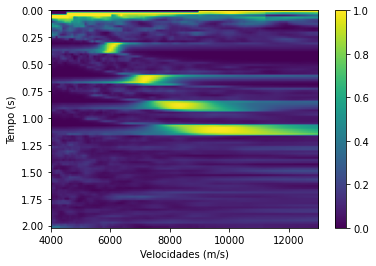

In [3]:
# Carregando e plotando o painel de semblance
dado = np.loadtxt("semblance.ascii") # Carregamos o dado

nt=101 #registros em tempo
nv=120 #velocidades
dado2=dado.reshape([nv,nt]) # Organizamos o dado em forma de matriz 

dt=0.02 #time shift
dv=75 #velocity shift
fv=4000 #primeira velocidade

plt.imshow(dado2.T,aspect="auto",extent=[fv, fv+nv*dv, nt*dt, 0])
plt.xlabel("Velocidades (m/s)")
plt.ylabel("Tempo (s)")
plt.colorbar()

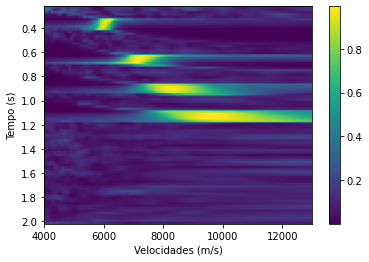

In [4]:
# Vamos mutar os primeiros segundos do painel, que não trazem informação relevante

dado_mute=dado2[:,10:-1]


plt.imshow(dado_mute.T,aspect="auto",extent=[fv, fv+nv*dv, nt*dt, 11*dt])
plt.xlabel("Velocidades (m/s)")
plt.ylabel("Tempo (s)")
plt.colorbar()

(120, 90) (120, 90)
(120, 90) (120, 90) (10800,)


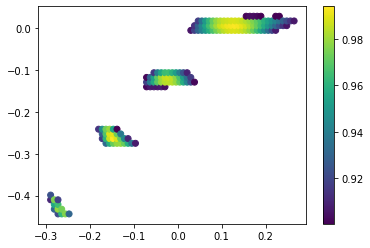

In [7]:
#Pre-processar dados para que as duas dimensões fiquem na mesma escala
def standardise(vector):
    media = np.mean(vector)
    desvpad = np.std(vector)
    stand=(vector-media)/desvpad
    return stand

def normalise(vector):
    media = np.mean(vector)
    maxi = np.max(vector)
    mini = np.min(vector)
    norma = (vector - media)/(maxi-mini)
    return norma


t = np.arange(11*dt,nt*dt,dt)
v= np.arange(fv,fv+nv*dv,dv)

times,velocities=np.meshgrid(t,v)

timesN=normalise(times.flatten())
velocitiesN=normalise(velocities.flatten())
print(times.shape,velocities.shape)

# Vamos selecionar apenas aquelas semblances maiores que um determinado threshold
filtro=dado_mute.flatten()>0.9
dado_clean=dado_mute.flatten()
#dado_clean[filtro]=0

print(times.shape,velocities.shape,filtro.shape)

X=np.zeros([len(dado_clean[filtro]),3])
X[:,0]=timesN[filtro]
X[:,1]=velocitiesN[filtro]
X[:,2]=0*normalise(dado_clean[filtro])


plt.scatter(X[:,1],X[:,0],c=dado_clean[filtro])
plt.colorbar()


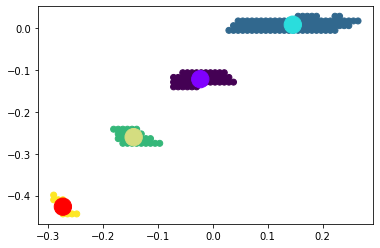

In [8]:
#Vamos calcular os centroides utilizando o k-means
from sklearn.cluster import KMeans
k=4
ctrds=np.zeros([k,3])
colors = cm.rainbow(np.linspace(0, 1, k)) # vou plotar cada centroide com uma cor
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)
pred_y = kmeans.fit_predict(X)

plt.scatter(X[:,1], X[:,0],c=pred_y)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:, 0], s=300, c=colors)

plt.show()

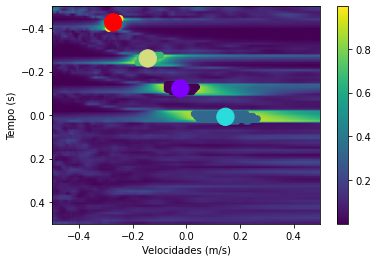

In [10]:
# E agora, vamos plotar os centroides sobre a imagem da semblance
clusters0 = np.zeros(dado_clean.shape)

clusters=clusters0.reshape([120,90])


dado_mute=dado2[:,10:-1]


plt.imshow(dado_mute.T,aspect="auto",extent=[min(velocitiesN), max(velocitiesN), max(timesN), min(timesN)])
plt.xlabel("Velocidades (m/s)")
plt.ylabel("Tempo (s)")
plt.colorbar()

plt.scatter(X[:,1], X[:,0],c=pred_y)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:, 0], s=300, c=colors)

In [5]:
def dist3(a1,a2,a3,b1,b2,b3):
    D = np.sqrt((a1-b1)**2+(a2-b2)**2+(a3-b3)**2)
    return D

def newCtrds3(y2):
    for j in range(k):
        ctrds[j,0]=np.mean(X[y2==j,0])
        ctrds[j,1]=np.mean(X[y2==j,1])
        ctrds[j,2]=np.mean(X[y2==j,2])
        

    
    return ctrds

def calculaDists3(X,ctrds):
    k=len(ctrds)
    y2=np.zeros(len(X))
    for i in range(len(X)):
        D = 1000000 #vou chutar um valor bem grande para D. 
        for j in range(k):
            D2 = dist3(X[i,0],X[i,1],X[i,2],ctrds[j,0],ctrds[j,1],ctrds[j,2])
            if D2 < D:
                D = D2
                y2[i]=j
                
    return(y2)



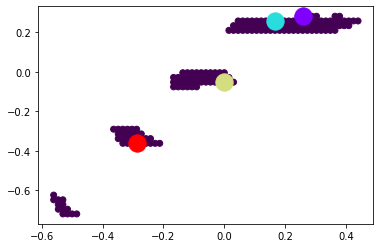

In [171]:
# Definir centroides iniciais

k=4
ctrds=np.zeros([k,3])
colors = cm.rainbow(np.linspace(0, 1, k)) # vou plotar cada centroide com uma cor

plt.scatter(X[:,1], X[:,0], c=X[:,2])
for i in range(k):
    j = np.random.randint(len(X))
    ctrds[i,0]=X[j,0]
    ctrds[i,1]=X[j,1]
    ctrds[i,2]=X[j,2]
    plt.scatter(ctrds[i,1],ctrds[i,0],s=300,color=colors[i])
 

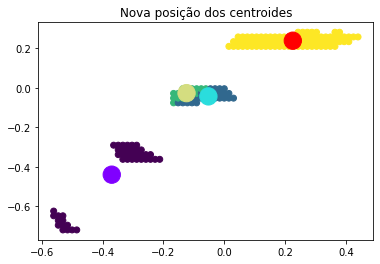

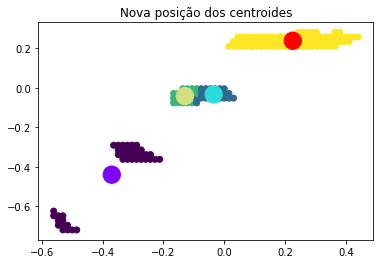

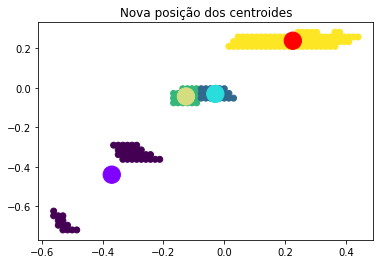

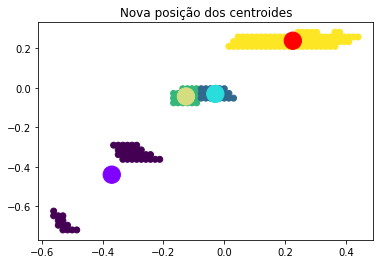

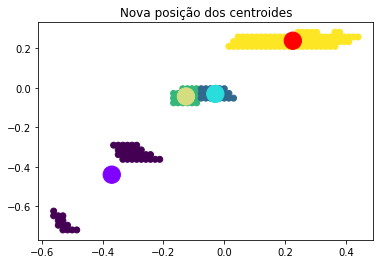

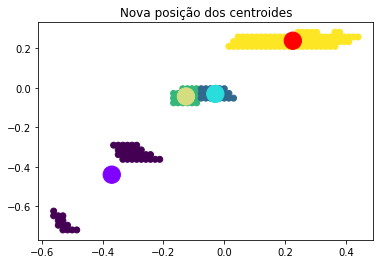

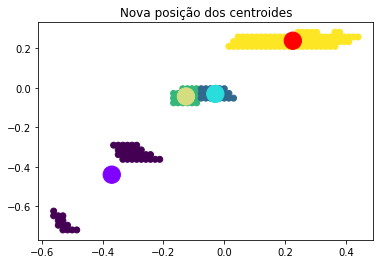

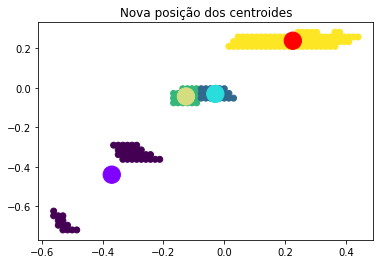

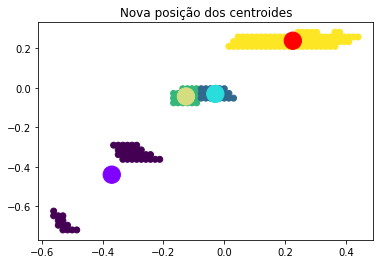

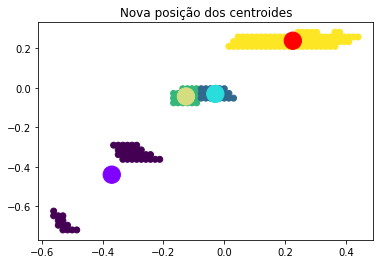

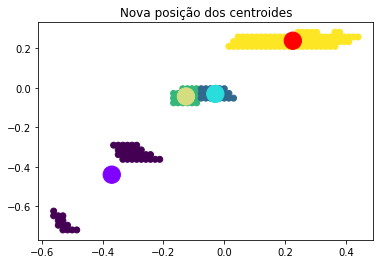

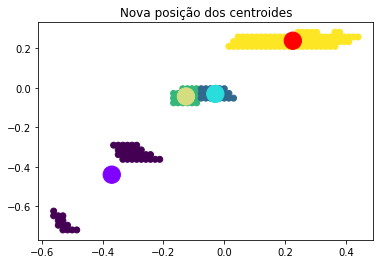

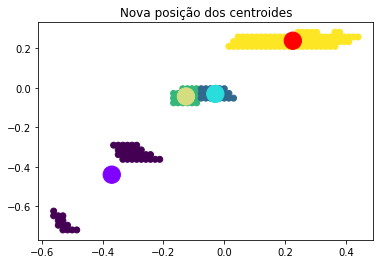

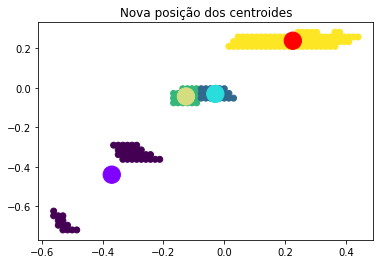

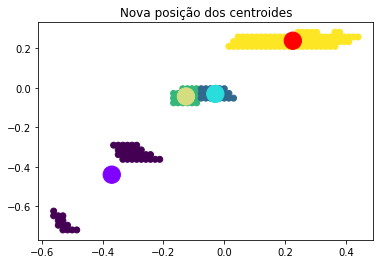

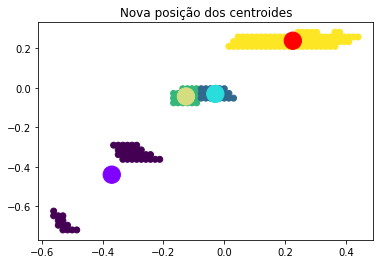

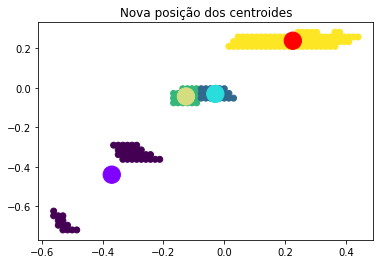

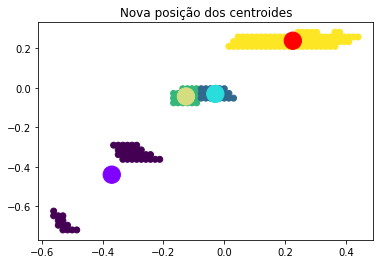

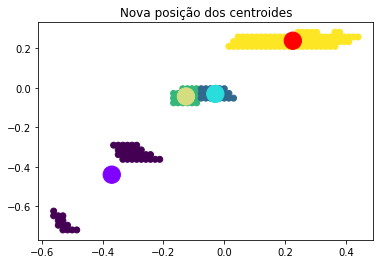

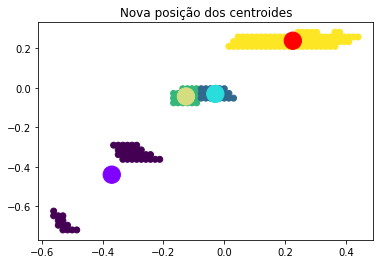

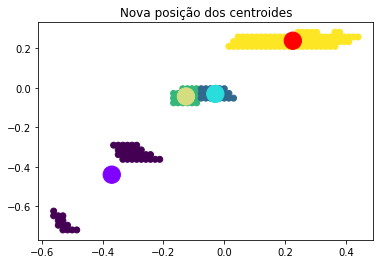

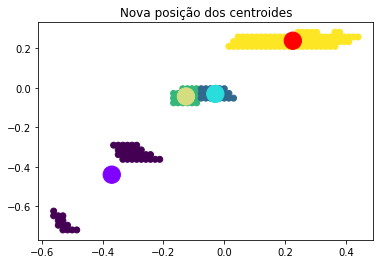

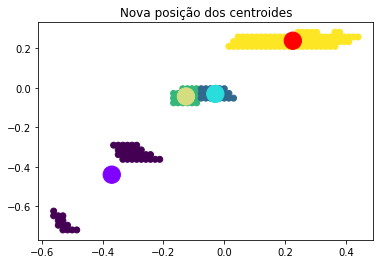

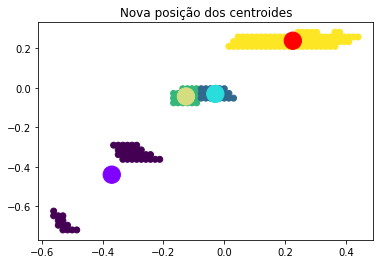

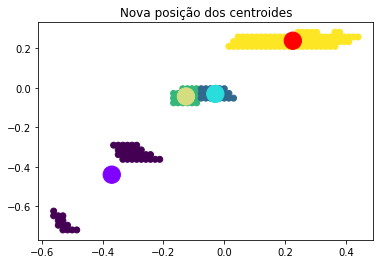

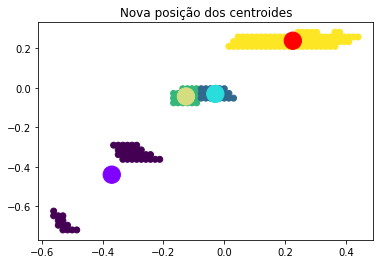

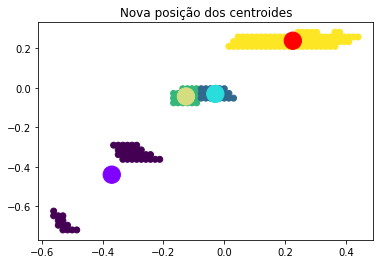

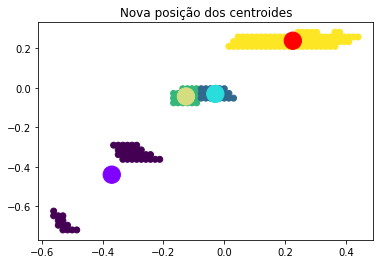

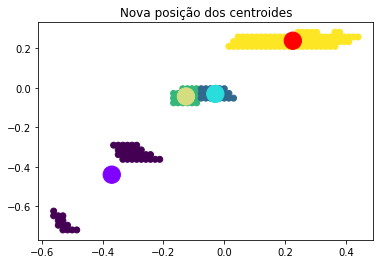

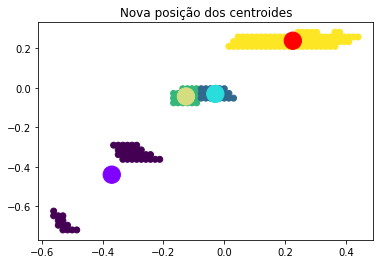

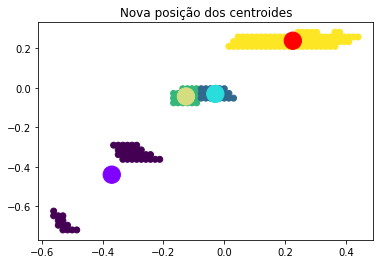

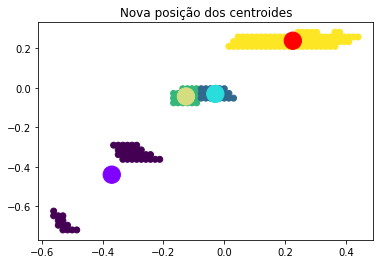

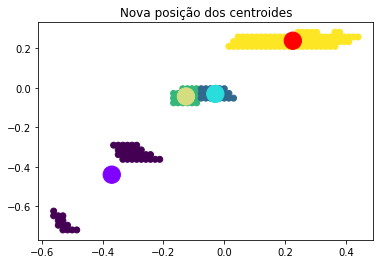

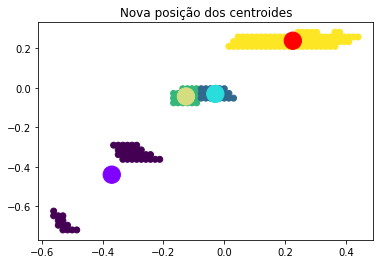

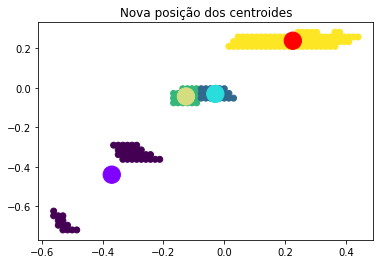

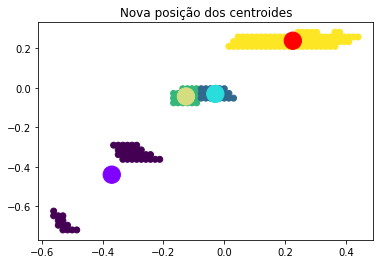

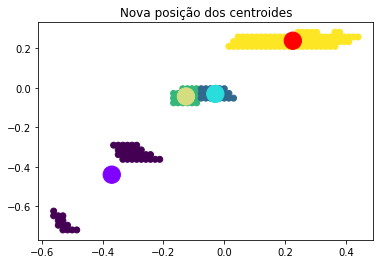

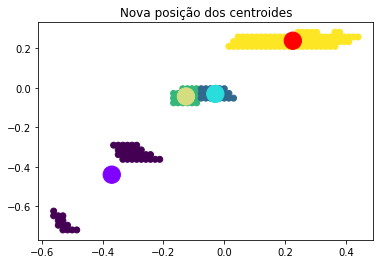

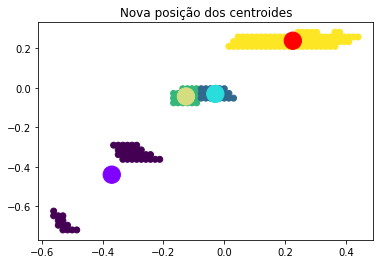

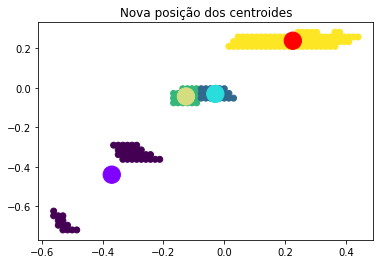

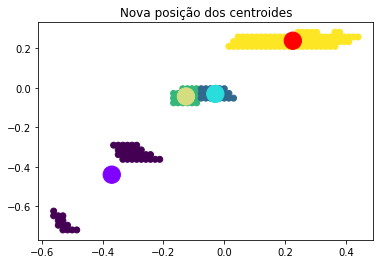

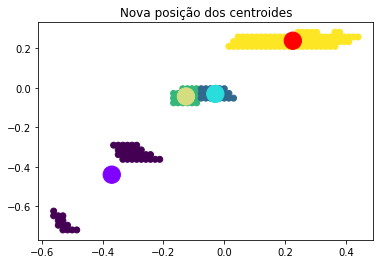

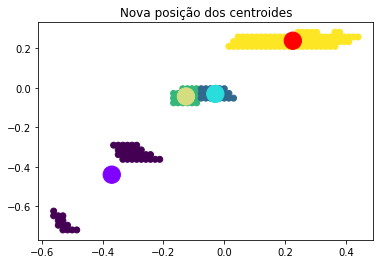

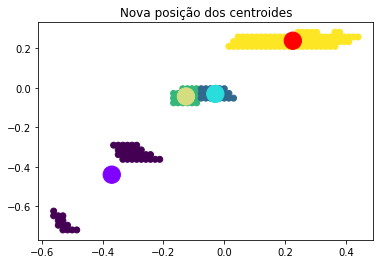

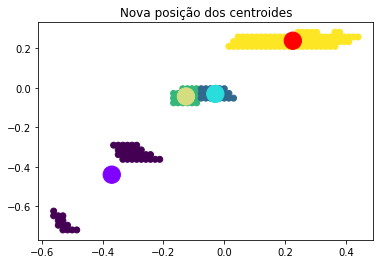

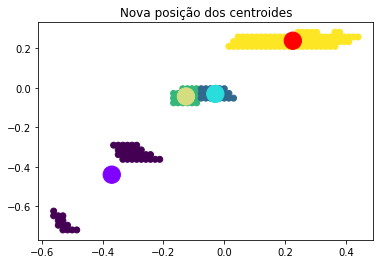

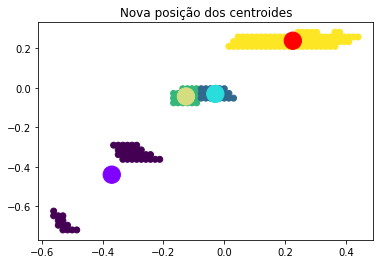

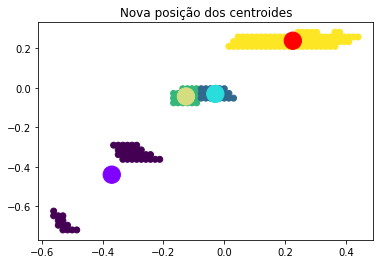

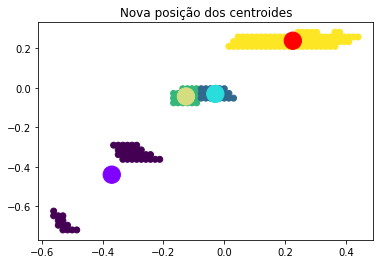

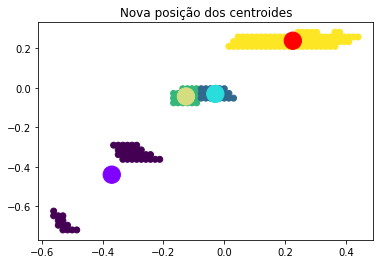

In [161]:
iter=0
Niter=50
while iter<Niter:
    y2 = calculaDists3(X,ctrds)
    ctrds = newCtrds3(y2)
    plt.scatter(X[:,1], X[:,0], c=y2)
    plt.scatter(ctrds[:,1],ctrds[:,0],s=300,c=colors)
    plt.title("Nova posição dos centroides")
    plt.pause(0.05)
    iter+=1

In [110]:
def dist1(a1,a2):
    D = np.sqrt((a1-a2)**2)
    return D

def newCtrds1(y2):
    for j in range(k):
        ctrds[j]=np.mean(X[y2==j])
        

    
    return ctrds

def calculaDists1(X,ctrds):
    k=len(ctrds)
    y2=np.zeros(len(X))
    for i in range(len(X)):
        D = 1000000 #vou chutar um valor bem grande para D. 
        for j in range(k):
            D2 = dist1(X[i],ctrds[j])
            if D2 < D:
                D = D2
                y2[i]=j
                
    return(y2)

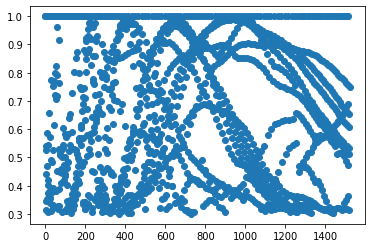

In [112]:
#Pre-processar dados

filtro=dado2.flatten()>0.3
dado_clean=dado2.flatten()

X=dado_clean[filtro]
plt.scatter(range(len(X)),X[:])


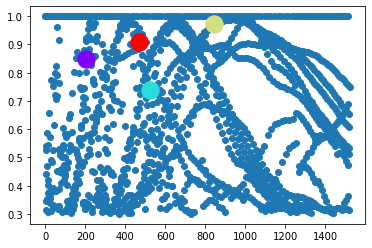

In [113]:
#Inicializar centroides
k=4
ctrds=np.zeros([k,1])
colors = cm.rainbow(np.linspace(0, 1, k)) # vou plotar cada centroide com uma cor

plt.scatter(range(len(X)),X[:])
for i in range(k):
    j = np.random.randint(len(X))
    ctrds[i]=X[j]
    plt.scatter(j,ctrds[i],s=300,color=colors[i])

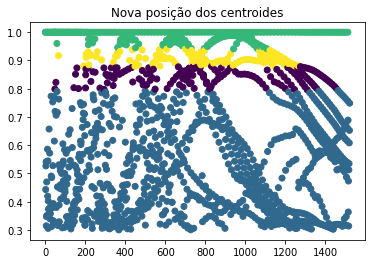

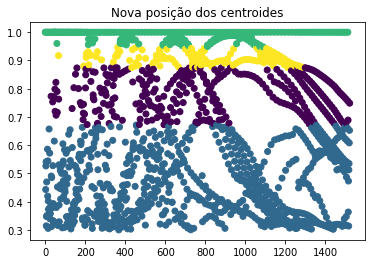

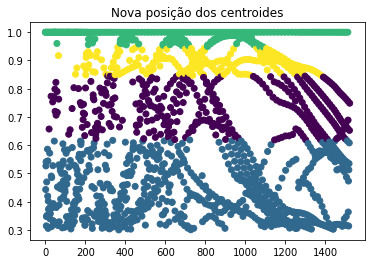

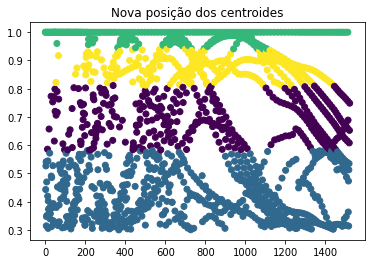

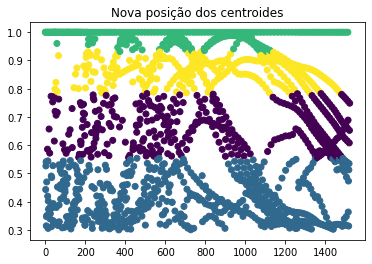

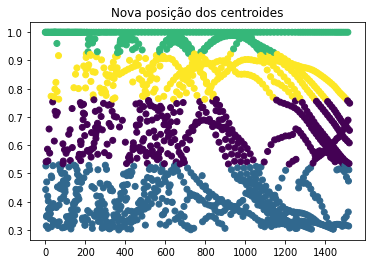

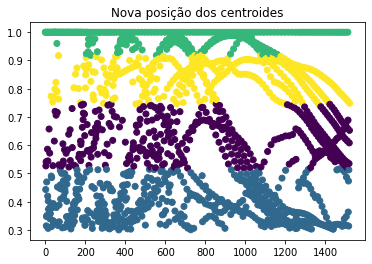

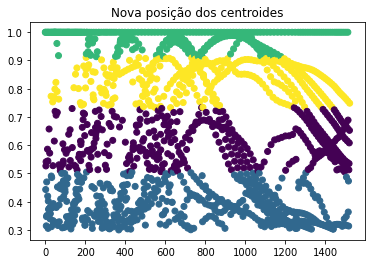

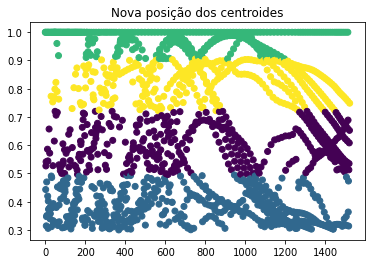

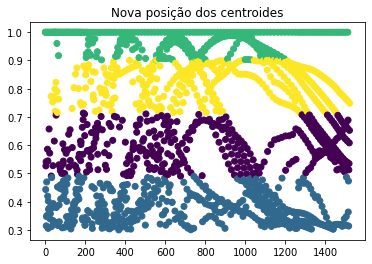

In [114]:
iter=0
Niter=10
while iter<Niter:
    y2 = calculaDists1(X,ctrds)
    ctrds = newCtrds1(y2)
    plt.scatter(range(len(X)), X[:], c=y2)
    #plt.scatter(,ctrds[:],s=300,c=colors)
    plt.title("Nova posição dos centroides")
    plt.pause(0.05)
    iter+=1

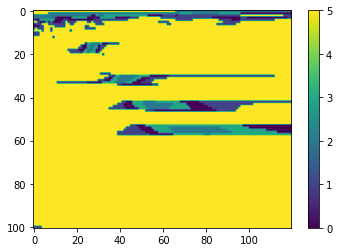

In [118]:
clusters0 = (k+1)*np.ones(dado_clean.shape)
clusters0[filtro]=y2

clusters=clusters0.reshape([120,101])
plt.imshow(clusters.T)
plt.colorbar()